In [126]:
# Pulse sequence version
import rotational_diffusion_photophysics as rdp
import numpy as np
import matplotlib.pyplot as plt
import codetiming

# Maximum l value for SH expansion
# lmax=6 is enough for good accuracy, with reasonable level of saturation.
# At high levels of satuaration use lmax=12 or lmax=20. After that it will be quite slow.
lmax = 6

# Objective parameters
numerical_aperture = 0.85 # 1.4
refractive_index = 1 # 1.518

# Create the illumination scheme
exc405X_488XY = rdp.ModulatedLasers(power_density=[     50,    2000,    2000],
                                    wavelength=   [    405,     488,     488],
                                    polarization= [    'x',    'xy',    'xy'],
                                    modulation=   [[0,1,0], [1,1,0], [0,0,1]],
                                    time_windows= [5e-3, 25e-3, 5e-3],
                                    time0=0e-3,
                                    numerical_aperture=numerical_aperture,
                                    refractive_index=refractive_index,
                                    )
# # Create the illumination scheme
# exc405X_488XY = rdp.ModulatedLasers(power_density=np.array([  10,  10,  30,  30]),
#                                     wavelength=   [405, 405, 488, 488],
#                                     polarization= ['x', 'y', 'x', 'y'],
#                                     modulation=[[0,1,1,1,1], [0,0,0,0,1], [1,1,0,1,1], [1,0,1,1,0]],
#                                     time_windows=[10e-3, 2e-3, 2e-3, 2e-3, 2e-3],
#                                     time0=10e-3,
#                                     numerical_aperture=numerical_aperture,
#                                     refractive_index=refractive_index,
#                                     )


# Create the detectors
detXY = rdp.PolarizedDetection(polarization=['x', 'y'],
                               numerical_aperture=numerical_aperture,
                               refractive_index=refractive_index,
                               )

# Create the fluorophore, with the photophysics
rsEGFP2 = rdp.NegativeSwitcher(extinction_coeff_on= [  5260, 51560],
                               extinction_coeff_off=[ 22000,    60],
                               wavelength=          [   405,   488],
                               lifetime_on=3e-9,
                               lifetime_off=20e-12,
                               quantum_yield_on_to_off=1.65e-2,
                               quantum_yield_off_to_on=0.33,
                               quantum_yield_on_fluo=0.35,
                               starting_populations=[1,0,0,0,0,0,0,0],
                               deprotonation_time_off=1e-6,  # 5.1 us
                               protonation_time_on=50e-6,
                               nspecies=8,
                               quantum_yield_trans_to_cis_anionic=0.02,
                               quantum_yield_cis_to_trans_neutral=0.,
                               )

# Diffusion models
iso500us = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*500e-6))
iso100us = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*100e-6))
iso10us = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*10e-6))
iso4us = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*4e-6))
iso1us = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*1e-6))
iso300ns = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*0.3e-6))
iso30ns = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*0.03e-6))

# Full system and experiment
starss2 = rdp.System(illumination=exc405X_488XY,
                     fluorophore=rsEGFP2,
                     diffusion=iso100us,
                     detection=detXY,
                     lmax=lmax)

# Solve the time evolution and time it for pesrformances
t = np.linspace(1e-6, 20e-3, 1000)
# t = np.logspace(-6, np.log10(5e-3), 100)

# Compute signals, it includes the analytical solution of the problem
timer = codetiming.Timer()
timer.start()
s = starss2.detector_signals(t)
timer.stop()

c = starss2._c
r = rdp.anisotropy(s)



Elapsed time: 2.6077 seconds
c:\Users\andre\Documents\GitHub\rotational_diffusion_photophysics\rotational_diffusion_photophysics.py:832: RuntimeWarning: overflow encountered in exp
  ci = np.matmul(ci0, np.diag(np.exp(L*time[i])))
c:\Users\andre\Documents\GitHub\rotational_diffusion_photophysics\rotational_diffusion_photophysics.py:832: RuntimeWarning: invalid value encountered in matmul
  ci = np.matmul(ci0, np.diag(np.exp(L*time[i])))


In [ ]:

label = 'new_exp_002_'

plt.figure()
plt.plot(t, c[:,0,:].T)
# plt.xscale('log')
plt.legend(np.arange(rsEGFP2.nspecies))
plt.xlabel('Time (us)')
plt.ylabel('Population')
plt.savefig(label+'population.png', dpi=300)

plt.figure()
plt.plot(t, r)
plt.ylim((-0.01, 0.2))
plt.xlabel('Time (us)')
plt.ylabel('Anisotropy')
plt.savefig(label+'anisotropy.png', dpi=300)

plt.figure()
plt.plot(t, s.T)
plt.xlabel('Time (s)')
plt.ylabel('Signal (a.u.)')
# plt.ylim((-0.5, 0.5))
plt.savefig(label+'signal.png', dpi=300)


In [116]:
tau_rot = [300e-6, 100e-6, 30e-6, 10e-6, 3e-6, 1e-6, 0.3e-6, 0.1e-6, 0.03e-6]
# tau_rot = np.logspace(np.log10(500e-6),np.log10(0.015e-6),8)
rs = np.zeros((np.size(tau_rot), t.size))
for i in np.arange(np.size(tau_rot)):
    diff_model = rdp.IsotropicDiffusion(diffusion_coefficient=1/(6*tau_rot[i]))
    starss2 = rdp.System(illumination=exc405X_488XY,
                     fluorophore=rsEGFP2,
                     diffusion=diff_model,
                     detection=detXY,
                     lmax=lmax)
    s = starss2.detector_signals(t)
    r = rdp.anisotropy(s)
    rs[i] = r

c:\Users\andre\Documents\GitHub\rotational_diffusion_photophysics\rotational_diffusion_photophysics.py:832: RuntimeWarning: overflow encountered in exp
  ci = np.matmul(ci0, np.diag(np.exp(L*time[i])))
c:\Users\andre\Documents\GitHub\rotational_diffusion_photophysics\rotational_diffusion_photophysics.py:832: RuntimeWarning: invalid value encountered in matmul
  ci = np.matmul(ci0, np.diag(np.exp(L*time[i])))


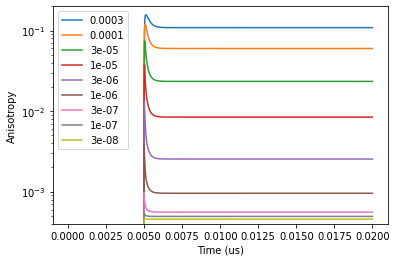

In [117]:
plt.plot(t, rs.T)
plt.ylim((0.0004,0.2))
plt.yscale('log')
plt.ylabel('Anisotropy')
plt.xlabel('Time (us)')
plt.legend(tau_rot)

plt.savefig(label+'anisotropy_multiple.png', dpi=300)


In [104]:
tau_rot

[0.0003, 0.0001, 3e-05, 1e-05, 3e-06, 1e-06, 3e-07, 1e-07, 3e-08]

In [105]:
exc405X_488XY.photon_flux
exc405X_488XY.power_density
rdp.photon_flux(exc405X_488XY.power_density, exc405X_488XY.wavelength)
rsEGFP2.cross_section_on
exc405X_488XY.photon_flux
starss2._K[0,1,0,0,0]

322995.28317427775

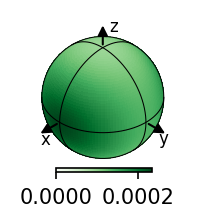

In [127]:
data = rdp.vec2grid(c[1,:,500])
from plot_data_sphere import plot_data_sphere
fig = plt.figure(dpi=150, figsize=[5,5])
ax = fig.add_subplot(231, projection='3d') 
plot_data_sphere(ax, data.data, scale=2, vmax=[])

ipykernel_launcher:1: RuntimeWarning: divide by zero encountered in log10


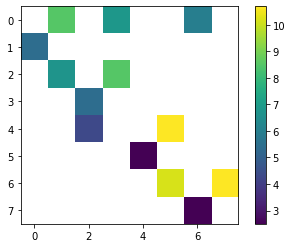

In [107]:
plt.imshow(np.log10(starss2._K[0,:,:,1,1]))
plt.colorbar()

In [108]:
starss2.illumination.photon_flux
starss2._F[:,0,0]

array([3.39802869e+19, 1.63776593e+21, 1.63776593e+21])